In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from keras.src.layers import SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import explained_variance_score

In [37]:
df = pd.read_csv('mbajk.csv')

In [38]:
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
0,2023-07-30 12:12:58+00:00,24.1,69,18.1,27.5,27.0,0.0,981.3,22,13
1,2023-09-11 20:14:06+00:00,19.2,85,16.6,20.9,0.0,0.0,981.7,22,0
2,2023-07-09 05:12:32+00:00,NaN,92,16.2,19.2,0.0,0.0,989.1,22,8
3,2023-07-21 12:37:13+00:00,NaN,64,17.2,27.2,94.0,0.0,978.8,22,14
4,2023-07-03 17:01:20+00:00,NaN,80,17.3,22.9,NaN,NaN,982.4,22,21


In [39]:
df['date'] = pd.to_datetime(df['date'])

In [40]:
df.sort_values(by=['date'], inplace=True)

In [41]:
df = df.reset_index(drop=True)
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
0,2023-06-25 19:07:30+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,8
1,2023-06-25 19:33:48+00:00,21.5,55,12.1,21.7,0.0,0.0,984.4,22,7
2,2023-06-25 19:45:44+00:00,21.5,55,12.1,21.7,0.0,0.0,984.4,22,6
3,2023-06-25 19:55:29+00:00,21.5,55,12.1,21.7,0.0,NaN,984.4,22,8
4,2023-06-25 20:02:16+00:00,21.5,55,12.1,21.7,NaN,0.0,984.4,22,12


In [42]:
df.dtypes

date                         datetime64[ns, UTC]
temperature                              float64
relative_humidity                          int64
dew_point                                float64
apparent_temperature                     float64
precipitation_probability                float64
rain                                     float64
surface_pressure                         float64
bike_stands                                int64
available_bike_stands                      int64
dtype: object

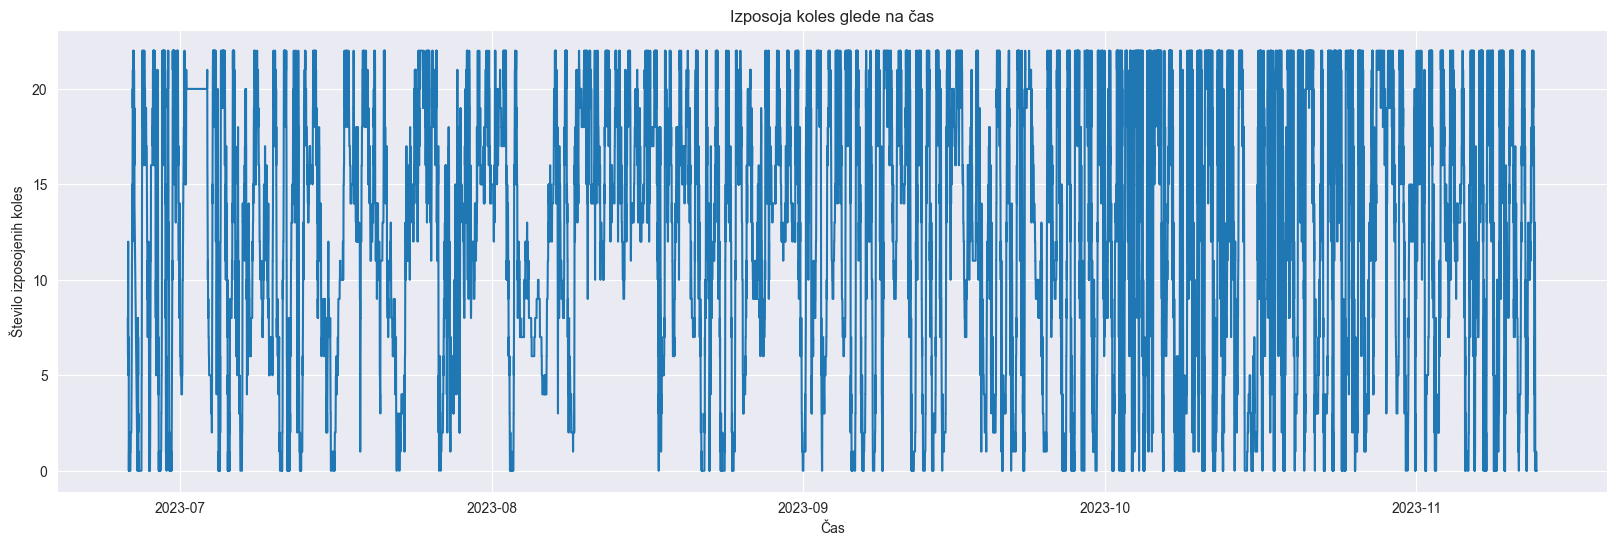

In [43]:
plt.figure(figsize=(20, 6))
plt.plot(df['date'], df['available_bike_stands'])
plt.title('Izposoja koles glede na čas')
plt.xlabel('Čas')
plt.ylabel('Število izposojenih koles')
plt.grid(True)

In [44]:
filtered_df = df['available_bike_stands']

In [45]:
# filtered_df = np.array(filtered_df)
dataset = filtered_df.values

In [46]:
test_data_size = 1488

train_data = dataset[:-test_data_size]
test_data = dataset[-test_data_size:]

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (26181,)
Test data shape: (1488,)


In [47]:
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

In [48]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [49]:
window_size = 186

def create_sequence_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size)]
        X.append(window)
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [50]:
X_train, y_train = create_sequence_data(train_data, window_size)
X_test, y_test = create_sequence_data(test_data, window_size)

In [51]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [52]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (25995, 1, 186)
Shape of X_test: (1302, 1, 186)
Shape of y_train: (25995, 1)
Shape of y_test: (1302, 1)


In [53]:
model_rnn = Sequential([
    SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(32),
    Dense(16, activation='relu'),
    Dense(1)
], name='RNN')

model_gru = Sequential([
    GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(1)
], name='GRU')

model_lstm = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
], name='LSTM')

models = [model_rnn, model_gru, model_lstm]

In [54]:
history = {}
for model in models:
    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2)
    history[model.name] = hist.history

Epoch 1/50
407/407 - 1s - loss: 0.0216 - 970ms/epoch - 2ms/step
Epoch 2/50
407/407 - 0s - loss: 0.0078 - 356ms/epoch - 875us/step
Epoch 3/50
407/407 - 0s - loss: 0.0065 - 353ms/epoch - 868us/step
Epoch 4/50
407/407 - 0s - loss: 0.0059 - 353ms/epoch - 866us/step
Epoch 5/50
407/407 - 0s - loss: 0.0055 - 355ms/epoch - 872us/step
Epoch 6/50
407/407 - 0s - loss: 0.0052 - 355ms/epoch - 872us/step
Epoch 7/50
407/407 - 0s - loss: 0.0050 - 355ms/epoch - 872us/step
Epoch 8/50
407/407 - 0s - loss: 0.0049 - 351ms/epoch - 863us/step
Epoch 9/50
407/407 - 0s - loss: 0.0047 - 356ms/epoch - 875us/step
Epoch 10/50
407/407 - 0s - loss: 0.0047 - 354ms/epoch - 871us/step
Epoch 11/50
407/407 - 0s - loss: 0.0046 - 352ms/epoch - 864us/step
Epoch 12/50
407/407 - 0s - loss: 0.0045 - 369ms/epoch - 906us/step
Epoch 13/50
407/407 - 0s - loss: 0.0044 - 352ms/epoch - 865us/step
Epoch 14/50
407/407 - 0s - loss: 0.0044 - 351ms/epoch - 863us/step
Epoch 15/50
407/407 - 0s - loss: 0.0044 - 357ms/epoch - 876us/step
Epoch 

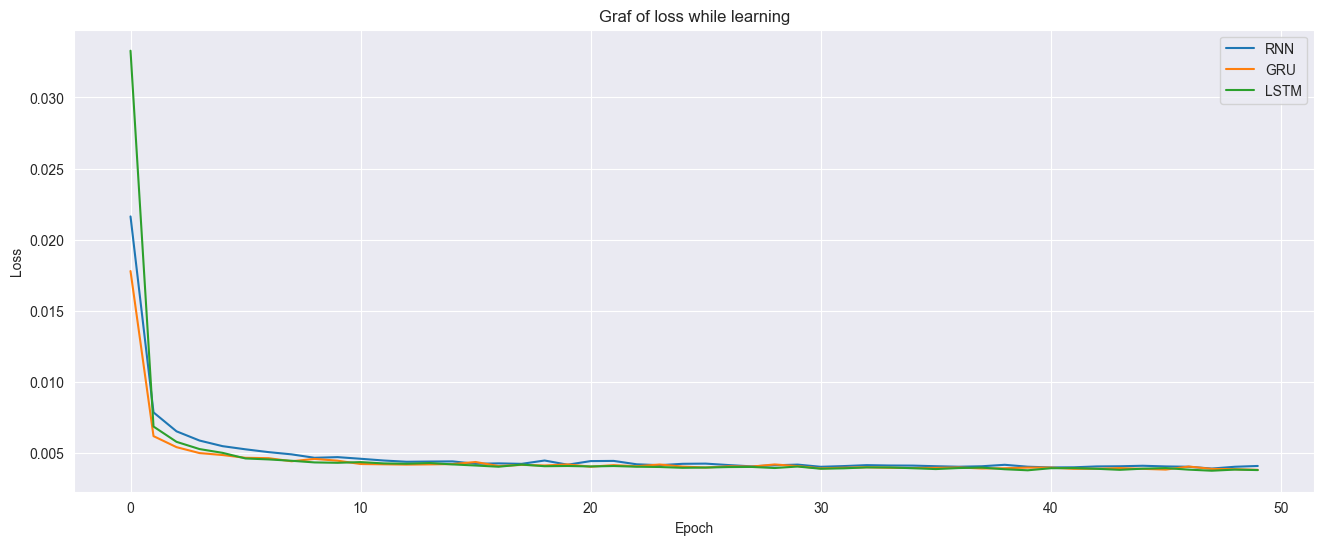

In [55]:
plt.figure(figsize=(16, 6))
for name, values in history.items():
    plt.plot(values['loss'], label=name)
plt.title('Graf of loss while learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
metrics = ['MSE', 'MAE', 'EVS']
def report(models, X_test, y_test, scaler):
    results = {
        'MSE': [],
        'MAE': [],
        'EVS': []
    }
    y_test = scaler.inverse_transform(y_test)
    for model in models:
        predicted = model.predict(X_test, verbose=0)
        predicted = scaler.inverse_transform(predicted)
       
        mse = mean_squared_error(y_test, predicted)
        mae = mean_absolute_error(y_test, predicted)
        evs = explained_variance_score(y_test, predicted)
        print(f'{model.name}:')
        print(f'MSE: {mse:.2f}')
        print(f'MAE: {mae:.2f}')
        print(f'EVS: {evs:.2f}')
        print()
        results['MSE'].append((model.name, mse))
        results['MAE'].append((model.name, mae))
        results['EVS'].append((model.name, evs))
    return results

In [57]:
regression_report = report(models, X_test, y_test, scaler)

RNN:
MSE: 2.72
MAE: 1.21
EVS: 0.95
GRU:
MSE: 2.76
MAE: 1.20
EVS: 0.95
LSTM:
MSE: 2.86
MAE: 1.23
EVS: 0.95


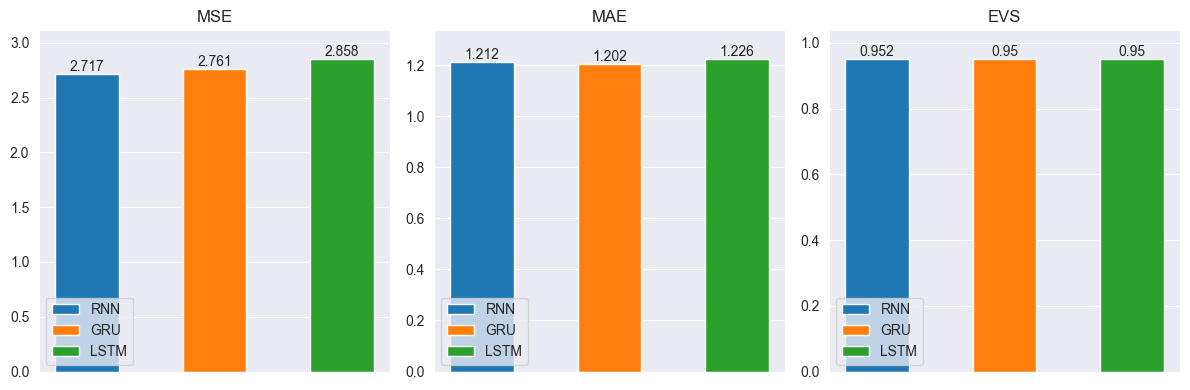

In [58]:
width = 0.5

rows = 1
cols = len(metrics)

fig, axs = plt.subplots(rows, cols, figsize=(12, 4))

for i, metric in enumerate(metrics):
    ax = axs[i]
    max = -float('inf')


    for j, model in enumerate(models):
        value = regression_report[metric][j][1]
        if value > max:
          max = value
        ax.bar(j, value, width, label=model.name)
        ax.text(j, value, str(round(value, 3)), ha='center', va='bottom')


    ax.set_ylim([0, max * 1.09])
    ax.set_title(f'{metric}')
    ax.set_xticks([], [])
    ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [59]:
dates = df['date'].values
print(dates)

['2023-06-25T19:07:30.000000000' '2023-06-25T19:33:48.000000000'
 '2023-06-25T19:45:44.000000000' ... '2023-11-12T23:34:21.000000000'
 '2023-11-12T23:44:27.000000000' '2023-11-12T23:54:32.000000000']


In [60]:
inverse_y_test = scaler.inverse_transform(y_test)
predictions = {}

for model in models:
    predicted = model.predict(X_test, verbose=0)
    predicted = scaler.inverse_transform(predicted)
    predictions[model.name] = predicted

In [61]:
output_df = {}

for model in models:
    data = {
        'date': dates[-test_data_size + window_size:],
        'true': inverse_y_test.reshape(-1),
        'predicted': predictions[model.name].reshape(-1)
    }
    output_df[model.name] = pd.DataFrame(data)

In [62]:
print(output_df['RNN'].head())

                 date  true  predicted
0 2023-11-07 05:49:07  12.0  12.099437
1 2023-11-07 05:52:30  12.0  12.205895
2 2023-11-07 05:58:13  14.0  12.182396
3 2023-11-07 06:02:42  16.0  14.116440
4 2023-11-07 06:08:58  17.0  16.261747


In [63]:
print(output_df['GRU'].head())

                 date  true  predicted
0 2023-11-07 05:49:07  12.0  12.586770
1 2023-11-07 05:52:30  12.0  12.431571
2 2023-11-07 05:58:13  14.0  12.254402
3 2023-11-07 06:02:42  16.0  14.255144
4 2023-11-07 06:08:58  17.0  16.091503


In [64]:
print(output_df['LSTM'].head())

                 date  true  predicted
0 2023-11-07 05:49:07  12.0  13.951618
1 2023-11-07 05:52:30  12.0  13.632849
2 2023-11-07 05:58:13  14.0  13.285341
3 2023-11-07 06:02:42  16.0  15.189878
4 2023-11-07 06:08:58  17.0  17.063524


In [65]:
def line_plot_test_data(df, model_name):
    plt.figure(figsize=(12, 8))
    plt.plot(df['date'], df['true'], label='True')
    plt.plot(df['date'], df['predicted'], label=model_name)
    plt.xlabel('Čas')
    plt.ylabel('Izposoje koles')
    plt.title('Izposoje koles glede na čas')
    plt.legend()
    plt.show()

In [66]:
def line_plot_all_data(df, model_df, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'].iloc[:-test_data_size], df['available_bike_stands'].iloc[:-test_data_size], label='Train')
    plt.plot(model_df['date'], model_df['predicted'], label=model_name, color='green')
    plt.plot(df['date'].iloc[-test_data_size:], df['available_bike_stands'].iloc[-test_data_size:], label='Test')
    plt.xlabel('Čas')
    plt.ylabel('Izposoje koles')
    plt.title('Izposoje koles glede na čas')
    plt.legend()
    plt.show()

RNN


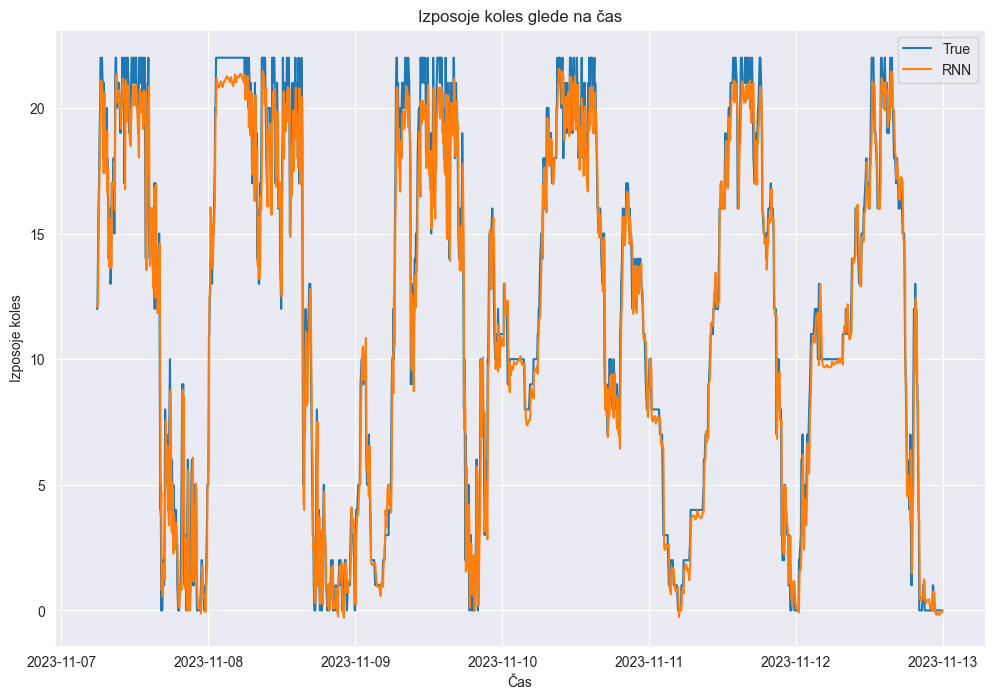

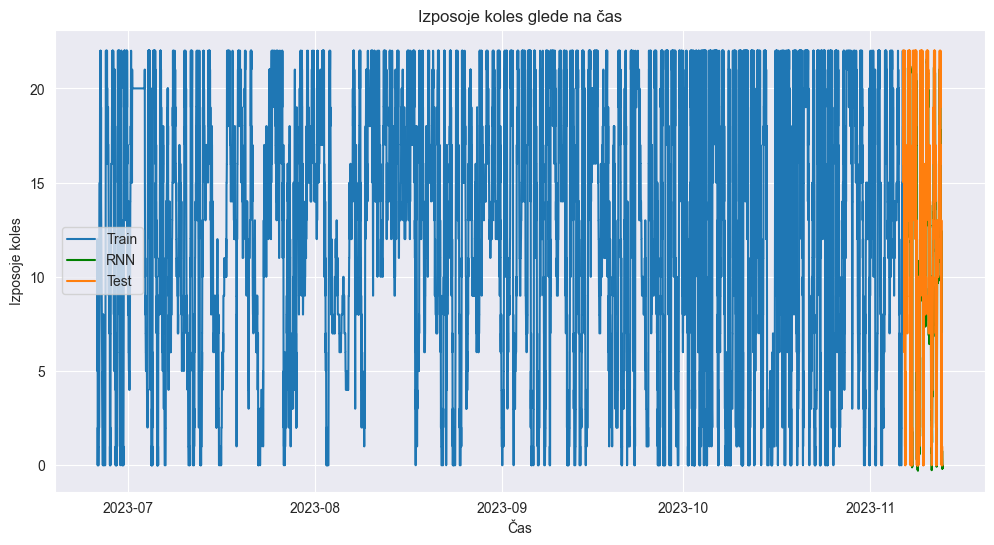

GRU


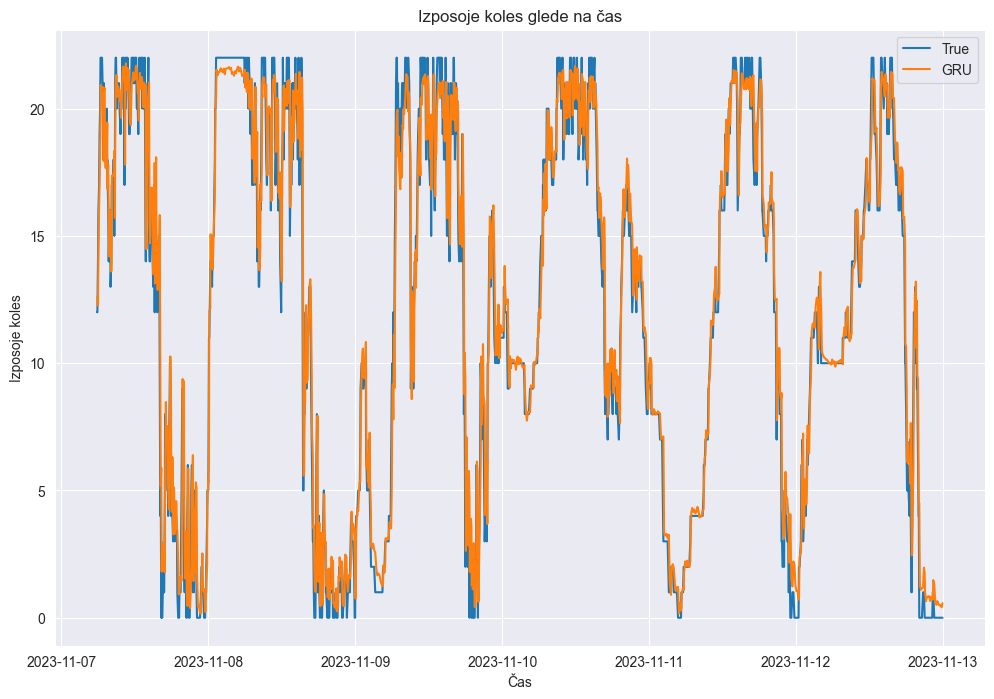

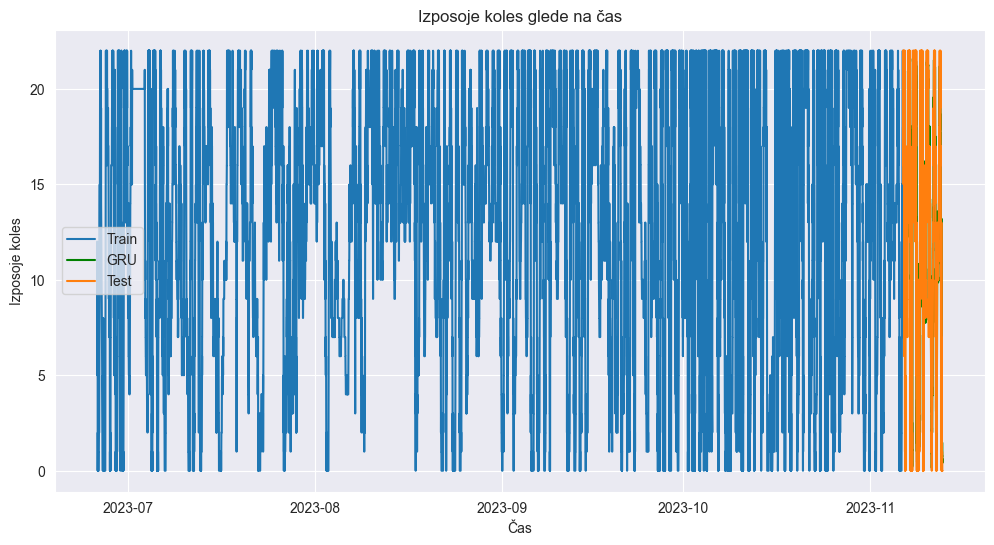

LSTM


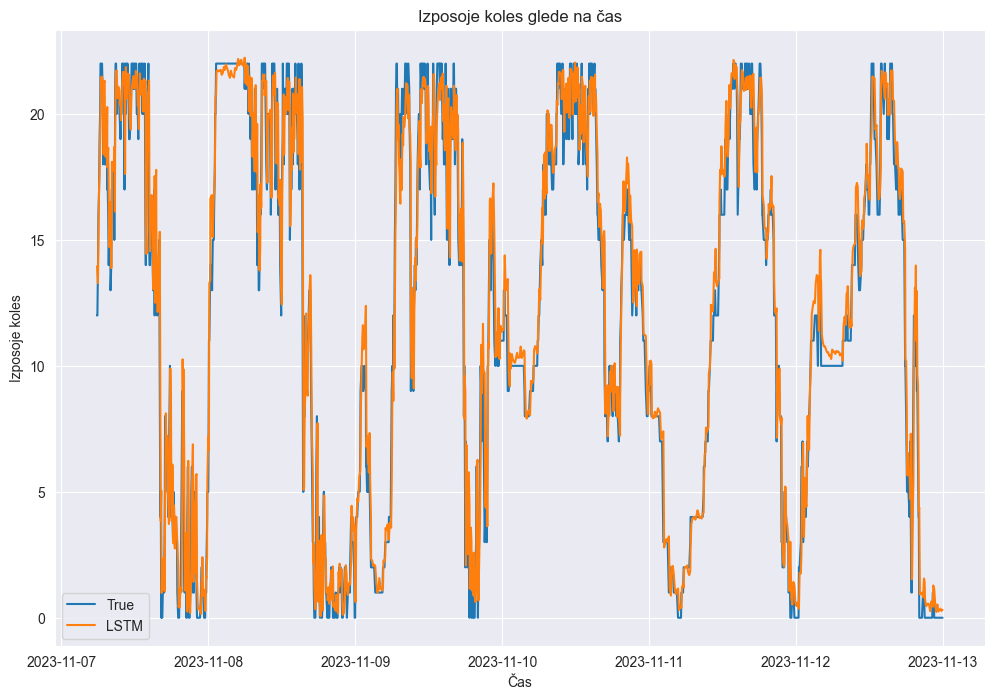

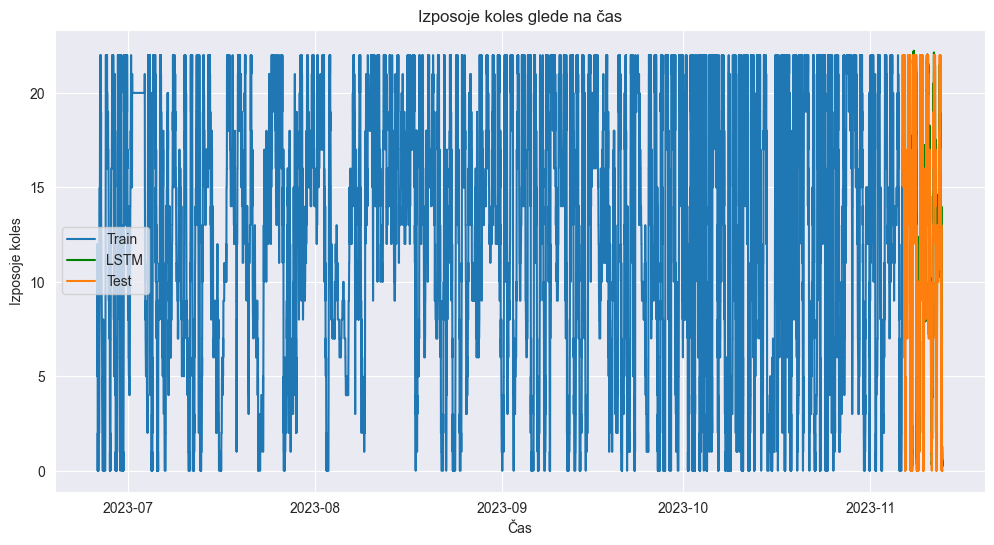

In [67]:
for model in models:
    print(model.name)
    line_plot_test_data(output_df[model.name], model.name)
    line_plot_all_data(df, output_df[model.name], model.name)